# Project File


In [25]:
# Importing common libraries 
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [26]:
data = pd.read_csv("data\\crime.csv", encoding='latin1')



In [27]:
subset_size = 500

In [28]:
data = data.sample(n=subset_size, random_state=42)

In [29]:
data.head()


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
35710,I182032558,3803,Motor Vehicle Accident Response,M/V ACCIDENT - PERSONAL INJURY,B2,179,NaN,2018-05-01 08:52:00,2018,5,Tuesday,8,Part Three,GERARD ST,42.330628,-71.072107,"(42.33062755, -71.07210653)"
270509,I152102923,614,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,D4,170,NaN,2015-12-13 17:07:00,2015,12,Sunday,17,Part One,MASSACHUSETTS AVE,42.335621,-71.075824,"(42.33562126, -71.07582361)"
74362,I172098993,1402,Vandalism,VANDALISM,C11,357,NaN,2017-11-28 22:49:00,2017,11,Tuesday,22,Part Two,WESTVILLE ST,42.300106,-71.071027,"(42.30010597, -71.07102710)"
968,I182069871,802,Simple Assault,ASSAULT SIMPLE - BATTERY,B2,319,NaN,2018-08-31 08:22:06,2018,8,Friday,8,Part Two,SEAVER ST,42.306040,-71.086212,"(42.30603974, -71.08621240)"
318360,I152049968,3301,Verbal Disputes,VERBAL DISPUTE,D14,939,NaN,2015-06-16 17:25:00,2015,6,Tuesday,17,Part Three,FANEUIL ST,42.355553,-71.152747,"(42.35555336, -71.15274721)"


In [30]:
data.drop(columns=['SHOOTING'], inplace=True)
data.dropna(inplace=True)

In [31]:
label_encoder = LabelEncoder()
data['DAYS_ENCODED'] = label_encoder.fit_transform(data['DAY_OF_WEEK'])
data['DISTRICT_ENCODED'] = label_encoder.fit_transform(data['DISTRICT'])
data['OFFENSE_CODE_GROUP_ENCODED'] = label_encoder.fit_transform(data['OFFENSE_CODE_GROUP'])
data['REPORTING_AREA_ENCODED'] = label_encoder.fit_transform(data['REPORTING_AREA'])
data['UCR_PART_ENCODED'] = label_encoder.fit_transform(data['UCR_PART'])
data['LOCATION_ENCODED'] = label_encoder.fit_transform(data['Location'])
data['STREET_ENCODED'] = label_encoder.fit_transform(data['STREET'])

y = data['DISTRICT_ENCODED']


In [32]:
columns_to_drop = ['INCIDENT_NUMBER', 'OFFENSE_CODE_GROUP', 'DISTRICT', 'OFFENSE_DESCRIPTION','REPORTING_AREA', 'OCCURRED_ON_DATE',
                  'DAY_OF_WEEK','UCR_PART','STREET_ENCODED','STREET','Location','DISTRICT_ENCODED']
X=data.drop(columns_to_drop, axis=1, inplace=True)


In [33]:
X

In [34]:
fields = list(data.columns[:-1])  # everything except the last column
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True, ascending=False)
correlations

REPORTING_AREA_ENCODED        0.191641
DAYS_ENCODED                  0.022451
YEAR                          0.017917
HOUR                          0.009650
OFFENSE_CODE_GROUP_ENCODED   -0.033217
OFFENSE_CODE                 -0.086450
MONTH                        -0.095492
UCR_PART_ENCODED             -0.114320
Lat                          -0.369583
Long                         -0.555583
dtype: float64

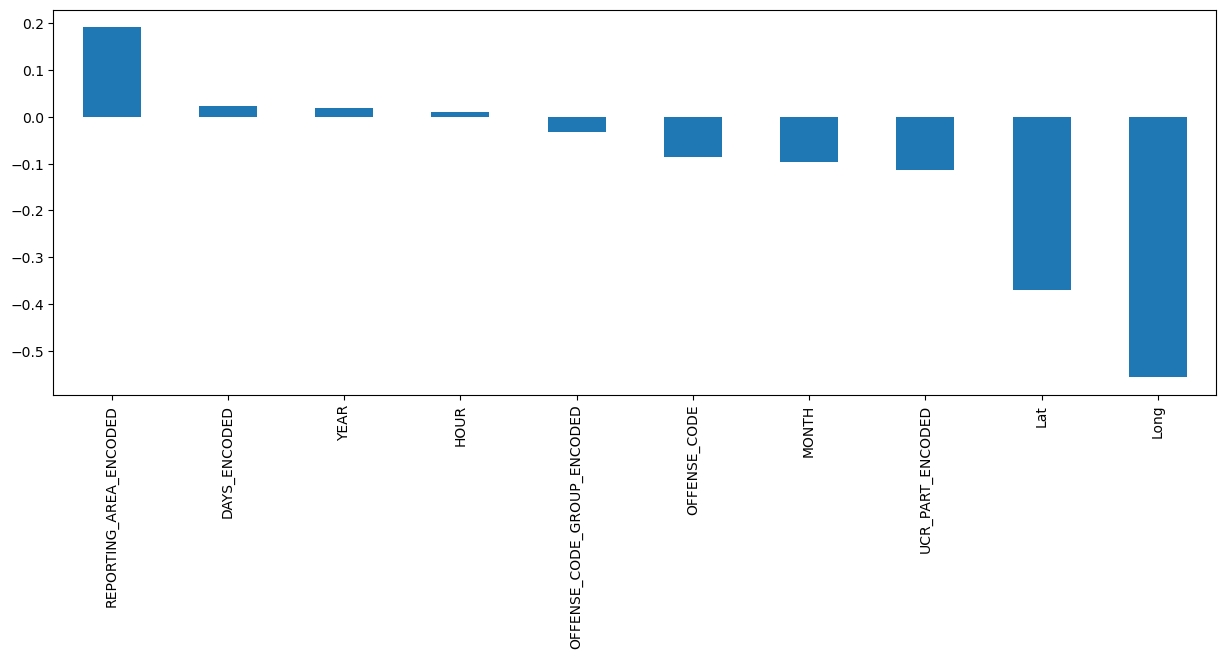

In [35]:
correlations.plot(kind='bar', figsize=(15,5))
plt.tick_params(labelsize=10);

In [36]:
#get top two features using absolute value of correlations (neg+pos)
correlations.abs().nlargest(2).index



Index(['Long', 'Lat'], dtype='object')

In [37]:
#get data using only top two columns from the correlation
X=data[correlations.abs().nlargest(2).index]

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

X=scaler.fit_transform(X)


In [39]:
#after scaling, data will be presented in numpy. For better plotting, it is best to turn them into dataframe again
X=pd.DataFrame(X, columns=correlations.abs().nlargest(2).index)


In [40]:
from sklearn.svm import SVC
#Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Set parameter
param_grid = {'C': [0.1,1,10],'kernel': ['linear', 'rbf', 'poly'], 'gamma': [1,0.1,10]}

#SMV
svm_classifier = SVC()


#Find the best value
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.9139784946236559


In [41]:


# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      0.71      0.83        17
           4       1.00      0.87      0.93        15
           5       0.82      1.00      0.90        14
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         8
           8       0.92      1.00      0.96        12
           9       0.73      1.00      0.84         8
          10       0.80      1.00      0.89         4
          11       1.00      1.00      1.00         2

    accuracy                           0.91        93
   macro avg       0.94      0.94      0.93        93
weighted avg       0.93      0.91      0.91        93

